# Visualising Data generated by Mutation testing

In the beginning of the project, I tried to get a glimpse of the generated data by trying out different visualizations,
the most basic beeing the covariance matrix, and then two different approaches. Below you can also load other datasets.

In [11]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import MDS

In [40]:
# Load datasets
def load_dataset(filename):
    mutants_and_tests = pd.read_pickle(filename)
    mutants_and_tests.reset_index()
    mutants_and_tests["outcome"] = mutants_and_tests["outcome"].astype('bool')
    mutants_and_tests["outcome"]
    #display(mutants_and_tests)
    return mutants_and_tests

datasets = {}
for name, filename in {'Flask': 'flask_full.pkl', 'Jinja': 'jinja_full.pkl', 'Httpie': 'httpie_full.pkl', 'Docopt': 'docopt_full.pkl'}.items():
    dataset = load_dataset('data/' + filename)
    datasets[name] = dataset
    

# Correlation Matrix

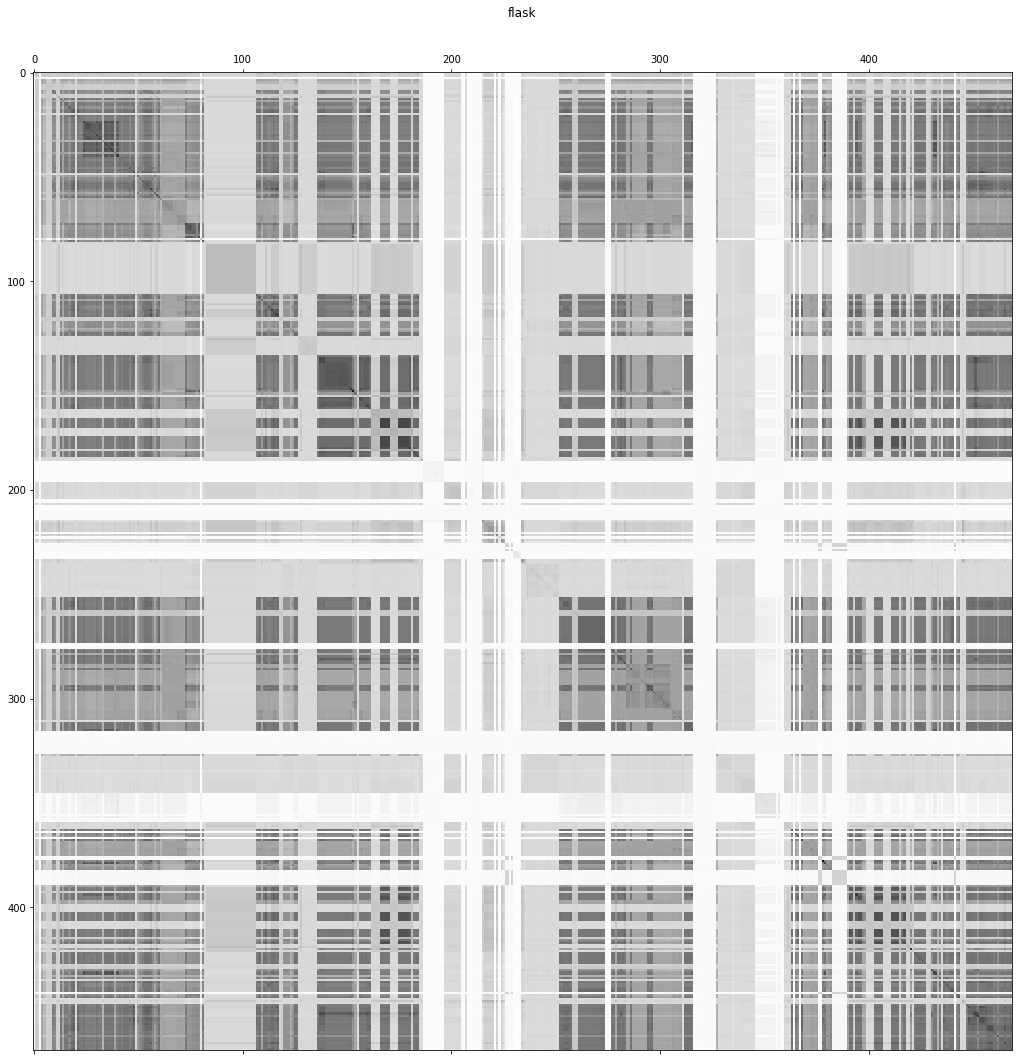

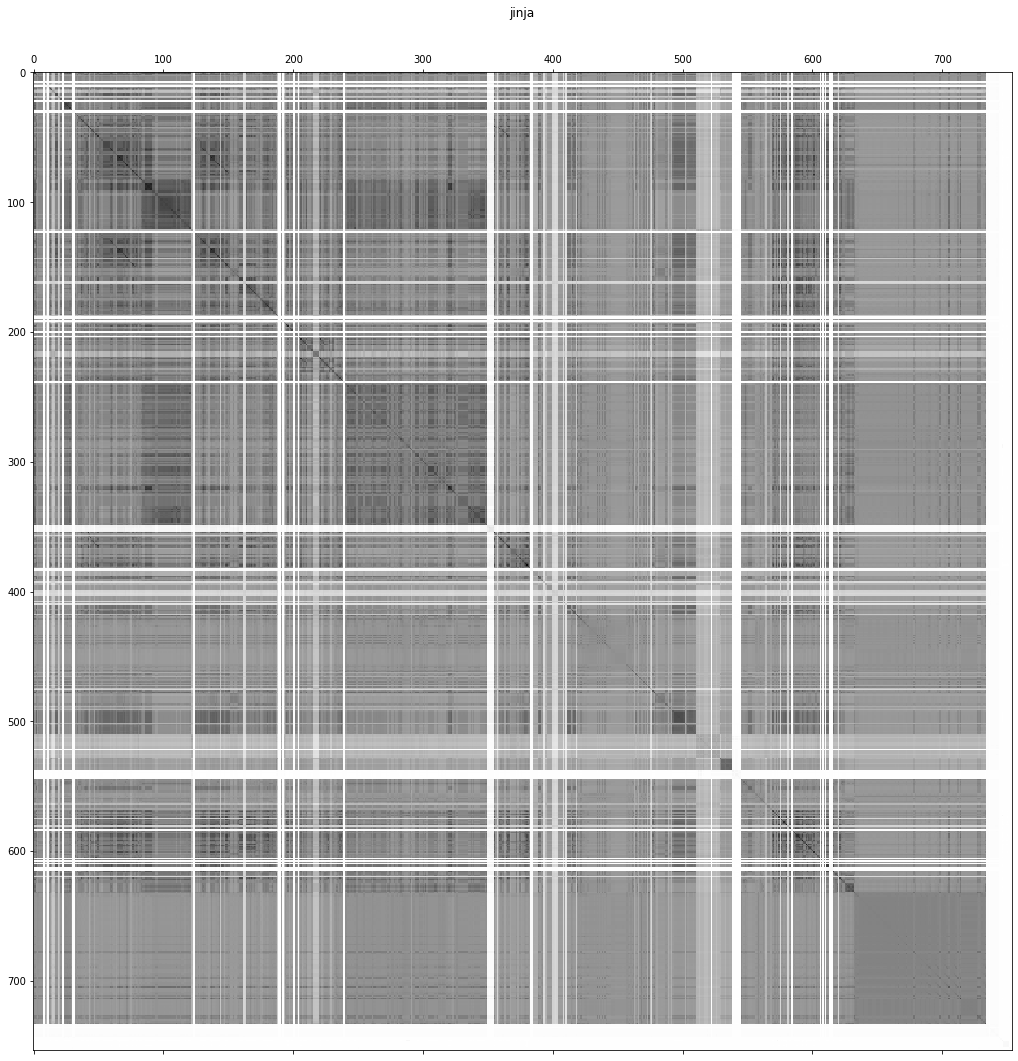

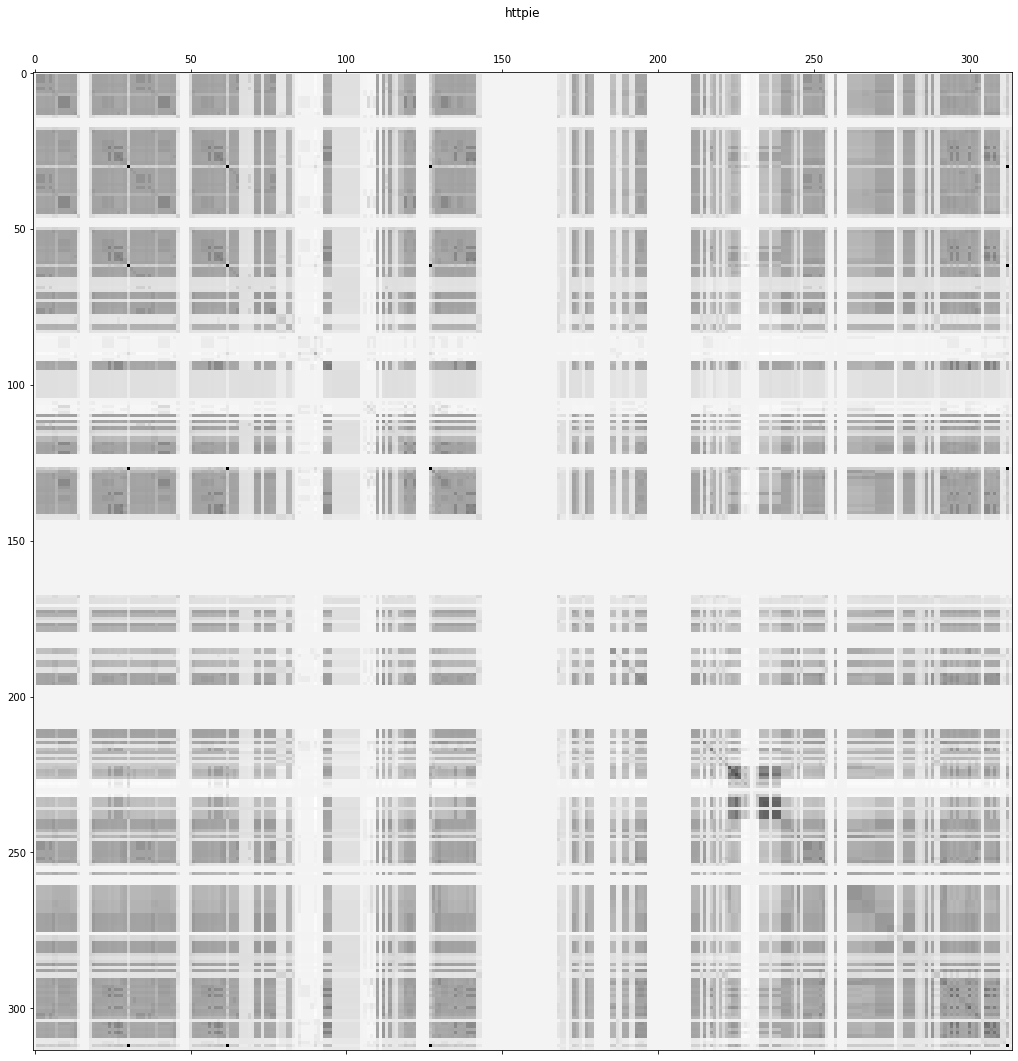

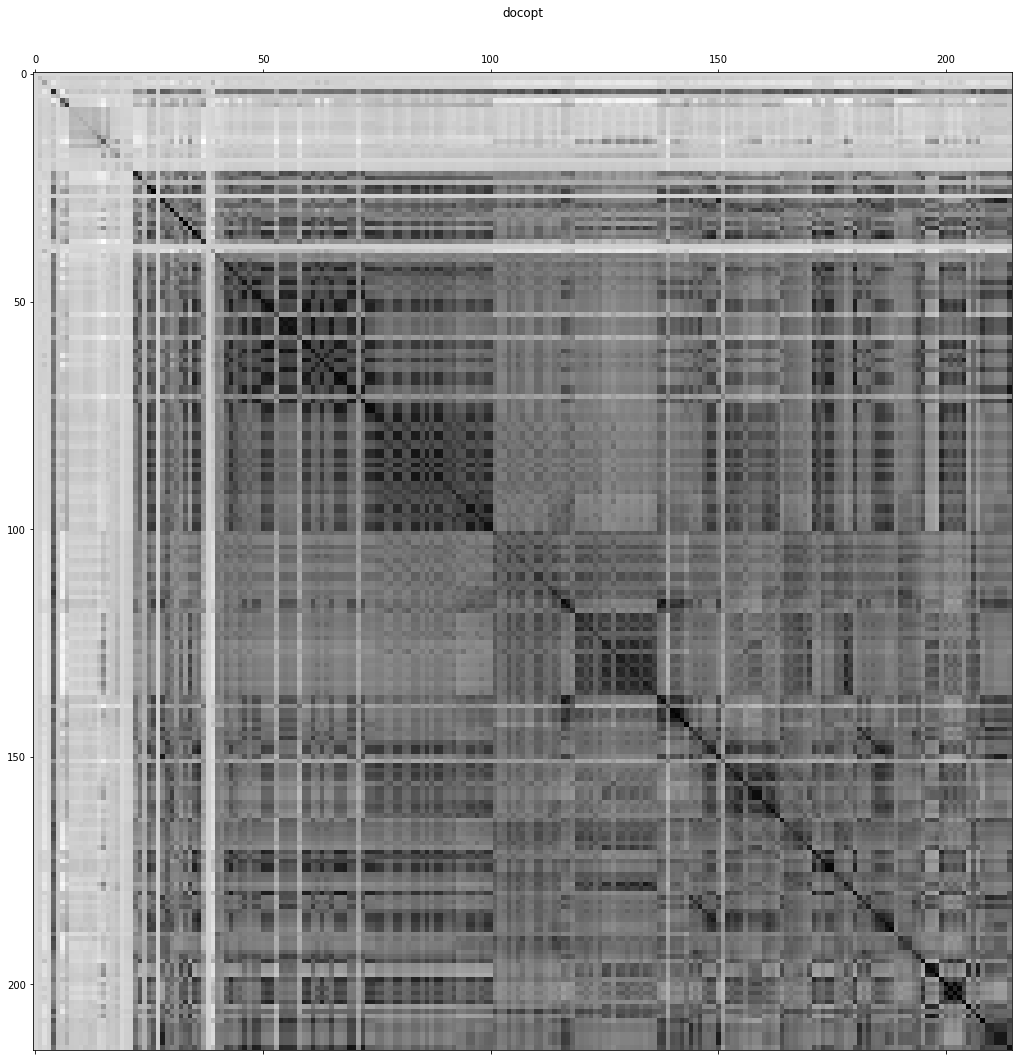

In [46]:
def plot_covariance_matrix(name, mutants_and_tests):
    pivot = mutants_and_tests.set_index('mutant_id').pivot(columns='test_id', values='outcome')
    pivot = pivot.astype('bool')
    fig, ax = plt.subplots(figsize=(18,18))
    ax.matshow(pivot.cov(), cmap=plt.get_cmap('binary'))
    #plt.axis('off')
    plt.title(name)
    plt.show()
    
for name, mutants_and_tests in datasets.items():
    plot_covariance_matrix(name, mutants_and_tests)

# 2D Embedding of Covariance Distances

Here the idea was to group tests together that have a high covariance, to get a structure of the test_cases.
The idea was to use the covariance as an approximate distance between them, and then try to lay this out in 2D.

In [48]:
mutants_and_tests = datasets['flask']

# Encoding
test_file_encoded = mutants_and_tests.groupby('test_id')['filepath'].first().astype('category').cat.codes


In [ ]:
pivot_without_failures = mutants_and_tests.pivot(columns='test_id', values='outcome')
pivot_without_failures.drop(pivot_without_failures.columns[0], axis=1, inplace=True)
# print(pivot.columns)
# display(pivot.cov())
pivot_without_failures = pivot_without_failures.astype('bool')
print(pivot_without_failures.shape)
# fig, ax = plt.subplots(figsize=(20,20))
# ax.matshow(pivot_without_failures.cov(), cmap=plt.get_cmap('Reds'))
# plt.show()

In [ ]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=10)
out = model.fit_transform( 1-pivot_without_failures.cov())
colorize = test_file_encoded
print(out.shape)
print(colorize.shape)
print(colorize)
plt.scatter(out[:, 0], out[:, 1], c=colorize[1:])
plt.axis('equal')

# Hierarchical Plot of tests


Since I didn't like the visualization of the embedding, I tried to come up with my own one:

We print one dot for every test, with the following properties:
x axis = average of ids of changed line (mutant_ids) that make this test fail
y axis = number of mutants that make test fail

So for example a unit test should be relatively wide down, since it should not fail on too many mutants.

To see the 'spread' of which mutant_ids made which tests fail, we draw an error from (mutant_id, 0) to (x,y) of the test, iff mutant_id make test fail

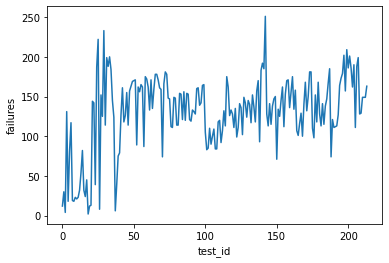

In [30]:
# First a plot of how often tests fail in general

failures = mutants_and_tests[mutants_and_tests['outcome'] == False]

fails_per_test_id = failures.groupby(['test_id']).count()['outcome']
#display(xy)

plt.plot(fails_per_test_id)
plt.xlabel('test_id')
plt.ylabel('failures')
plt.show()

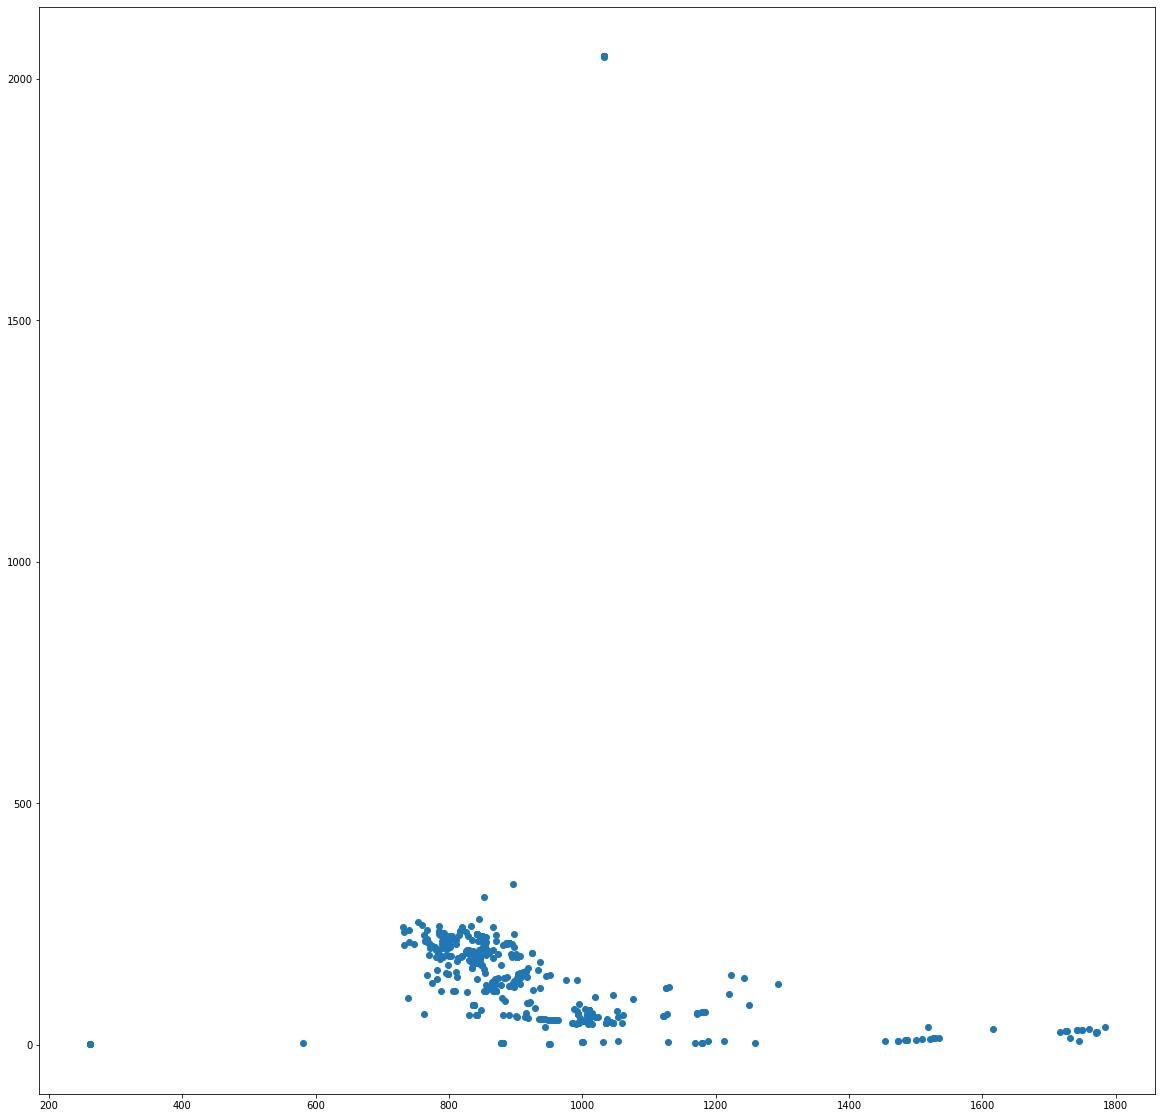

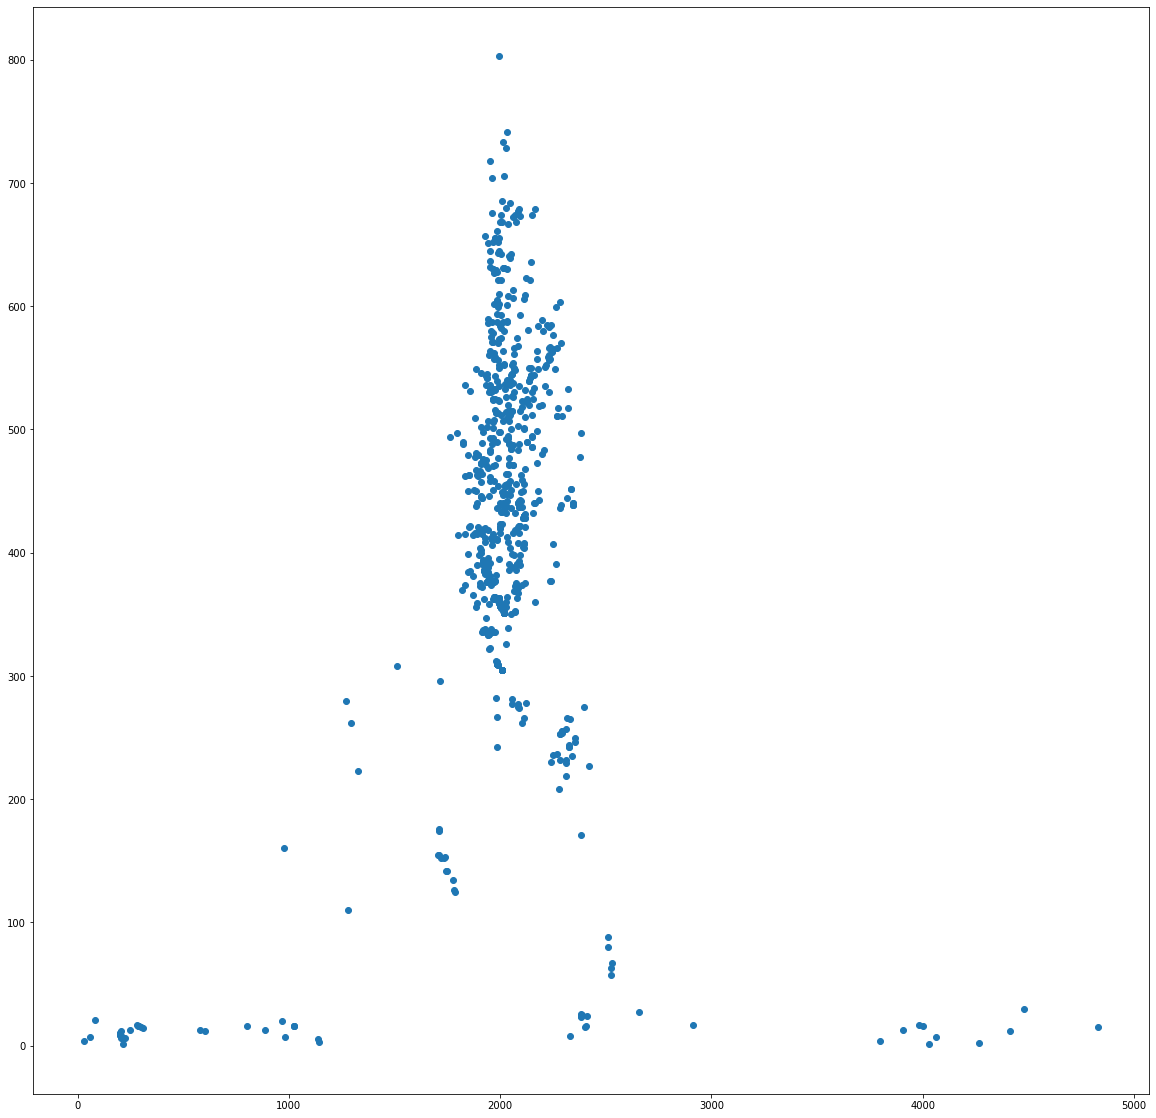

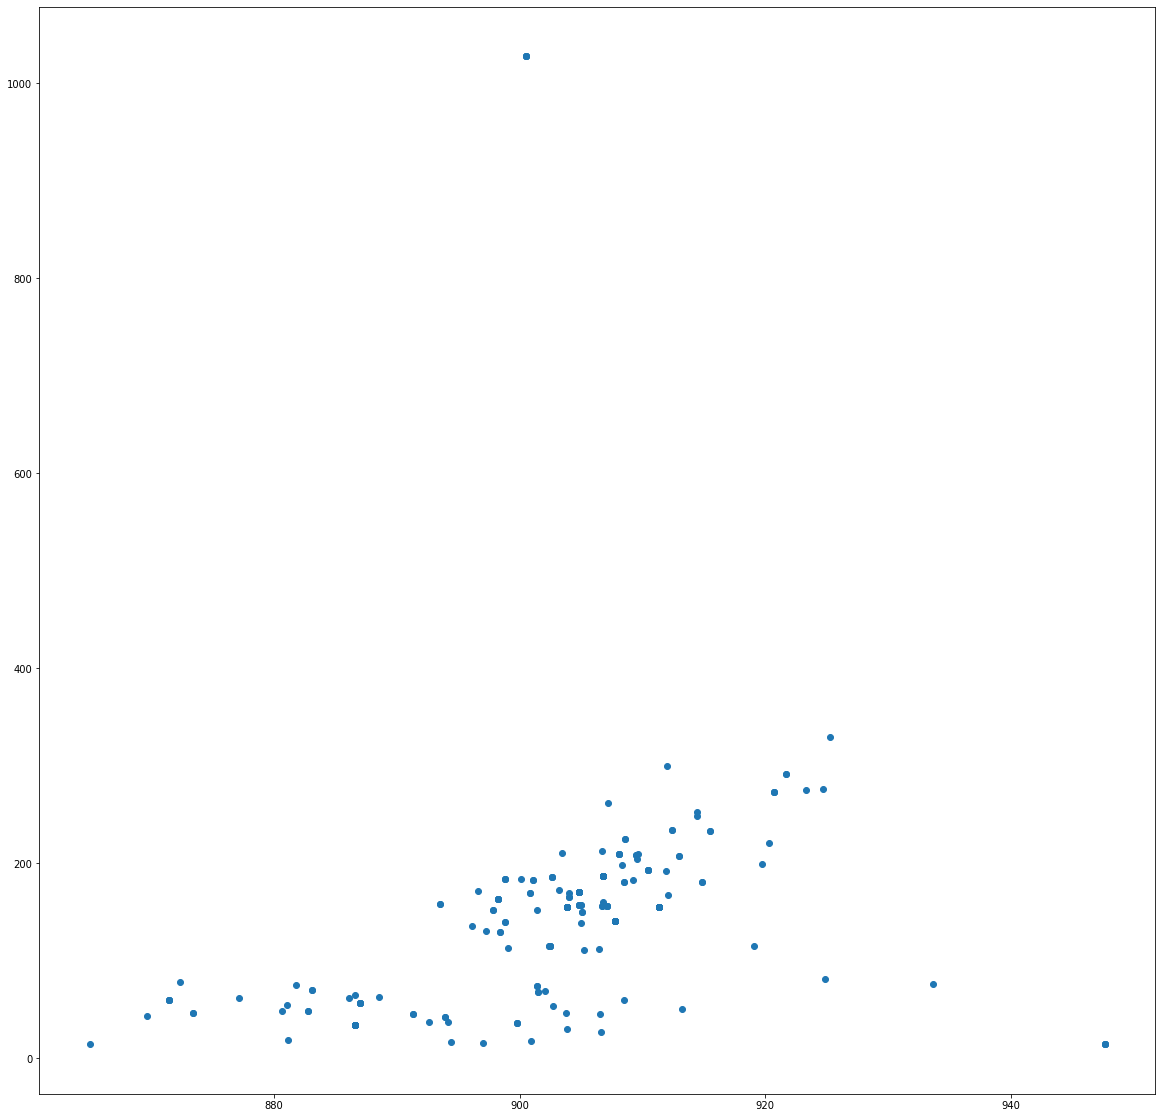

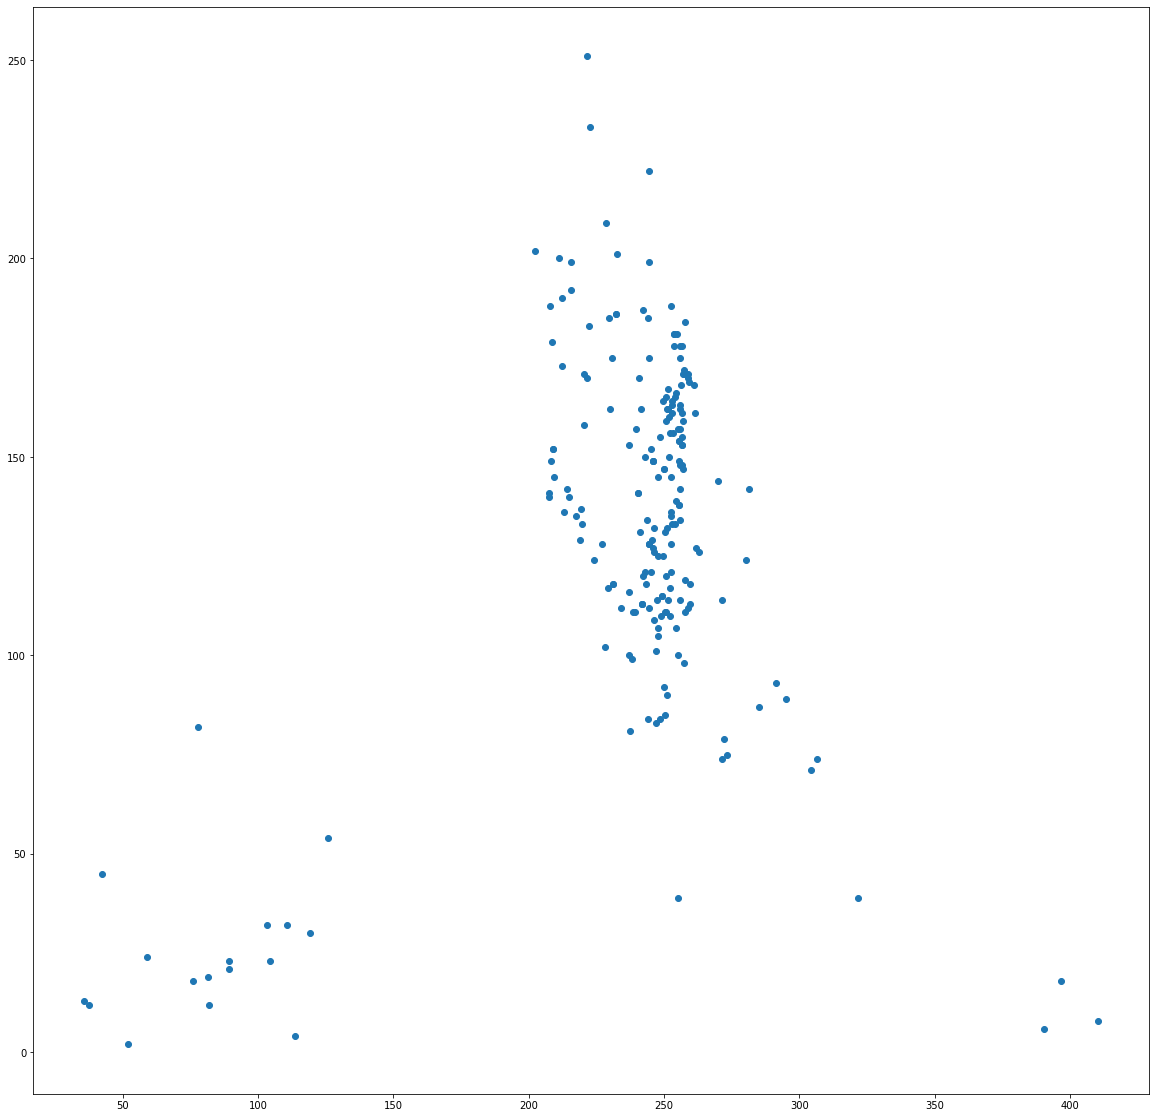

In [37]:
# TODO: Factor into method
# For larger datasets, this takes minutes. You can disable the arrows, if you want it fast :D

def hierarchical_plot(mutants_and_tests, arrows=True):
    failures = mutants_and_tests[mutants_and_tests['outcome'] == False]
    fails_per_test_id = failures.groupby(['test_id']).count()['outcome']
    
    y = fails_per_test_id
    x = failures.reset_index().groupby(['test_id']).mean()['mutant_id']
    #display(x)
    #display(y)


    fig, ax = plt.subplots(1,1,figsize=(20,20))
    #ax.set_xlim(0, 2100)
    #ax.set_ylim(0,500)
    ax.scatter(x=x, y=y)
    #print(failures.reset_index().columns)
    if(arrows):
        for test_failure in failures.reset_index().itertuples():
            #print(test_failure)
            x_start = test_failure.mutant_id # mutant_id
            y_start = 0
            test_id = test_failure.test_id
            x_end = x[test_id]
            y_end = y[test_id]
            #print(x_start)
            #print(y_start)
            #print(x_end)
            #print(y_end)
            ax.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start), arrowprops={'arrowstyle': '->', 'color': '#A0A0A005'})
    plt.show()

for mutants_and_tests in datasets:
    hierarchical_plot(mutants_and_tests, arrows=False)